## Quantify image similarity across subsequent frames

In [1]:
#import pytubefix
import os

#os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/anaconda3/envs/ponce/lib/python3.13/site-packages/imageio_ffmpeg/binaries/ffmpeg"

#import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt

from core.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.GAN_utils import loadBigGAN, BigGAN_wrapper
from core.utils.GAN_invert_utils import *
from core.utils.GAN_utils import upconvGAN

from core.utils.image_similarity import *
from core.utils.CNN_scorers import TorchScorer

import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import special_ortho_group

/n/home09/dsprague/.conda/envs/ponce_rotation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data_dir = '/Users/dysprague/Ponce_rotation/data'
data_dir = r"/n/home09/dsprague/data"

In [3]:
def count_frames(folder_path, tag):
    # Regular expression pattern to match 'frame_i_inverted.png' files
    pattern = re.compile(f'^frame_\d+_{tag}\.png$')
    
    # Count files that match the pattern
    frame_count = sum(1 for file_name in os.listdir(folder_path) if pattern.match(file_name))
    
    return frame_count

In [4]:
def get_image_similarity(path1, path2, tag1, tag2):
    
    frames_1 = count_frames(path1,tag1)
    frames_2 = count_frames(path2,tag2)
    
    images_1 = [f'frame_{i}_{tag1}.png' for i in range(frames_1)]
    images_2 = [f'frame_{i}_{tag2}.png' for i in range(frames_2)]
    
    if len(images_1) != len(images_2):
        images_1 = images_1[:min(len(images_1), len(images_2))]
        images_2 = images_2[:min(len(images_1), len(images_2))]
                            
    batch_1  = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path1, image)).transpose(2,0,1) for image in images_1]))
    batch_2 = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path2, image)).transpose(2,0,1) for image in images_2]))
    
    sim_scorer = TorchImageDistance()
    sim_scorer.first_image_batch = batch_1 
    sim_scorer.second_image_batch = batch_2
    
    mean_simmat, simmat = sim_scorer.get_CCN_distance()
    
    return mean_simmat, simmat

In [5]:
def get_similarity_frames(path, tag):
    
    frames = count_frames(path, tag)
    
    images = [f'frame_{i}_{tag}.png' for i in range(frames)]
              
    images_1 = images[:-1]
    images_2 = images[1:]
              
    batch_1  = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path, image)).transpose(2,0,1) for image in images_1]))
    batch_2 = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path, image)).transpose(2,0,1) for image in images_2]))
              
    sim_scorer = TorchImageDistance()
    sim_scorer.first_image_batch = batch_1 
    sim_scorer.second_image_batch = batch_2
    
    mean_simmat, simmat = sim_scorer.get_CCN_distance()
    
    return mean_simmat, simmat

In [29]:
mean_sim_frames, sim_frames = get_similarity_frames(os.path.join(data_dir, 'videos_inverted', 'horses'), 'original')
mean_sim_frames_inv, sim_frames_inv = get_similarity_frames(os.path.join(data_dir, 'videos_inverted', 'horses'), 'inverted')

The CNN scorers are set
The CNN scorers are set


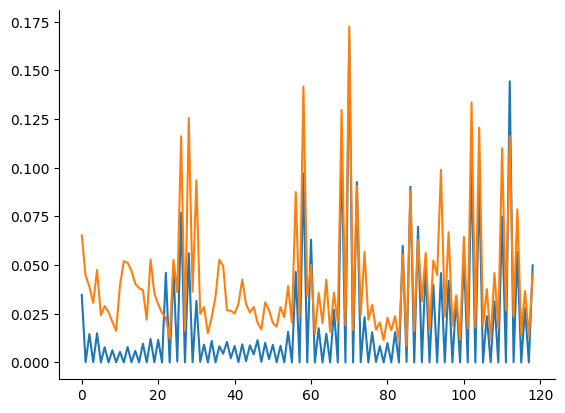

In [22]:
fig = plt.figure()

plt.plot(mean_sim_frames, label='original')
plt.plot(mean_sim_frames_inv, label='inverted')

plt.show()

In [98]:
frame_diff = {}

for folder in os.listdir(os.path.join(data_dir, 'videos_inverted')):
    if folder == '.DS_Store':
        continue
        
    path = os.path.join(data_dir, 'videos_inverted', folder)
    
    mean_sim_frames, sim_frames = get_similarity_frames(path, 'original')
    mean_sim_frames_inv, sim_frames_inv = get_similarity_frames(path, 'inverted')
    
    num_frames = len(mean_sim_frames)
    time = np.arange(num_frames)*2/num_frames
    
    frame_diff[folder] = {'original': mean_sim_frames, 'inverted': mean_sim_frames_inv, 'diff': np.abs(mean_sim_frames_inv - mean_sim_frames)}

The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set


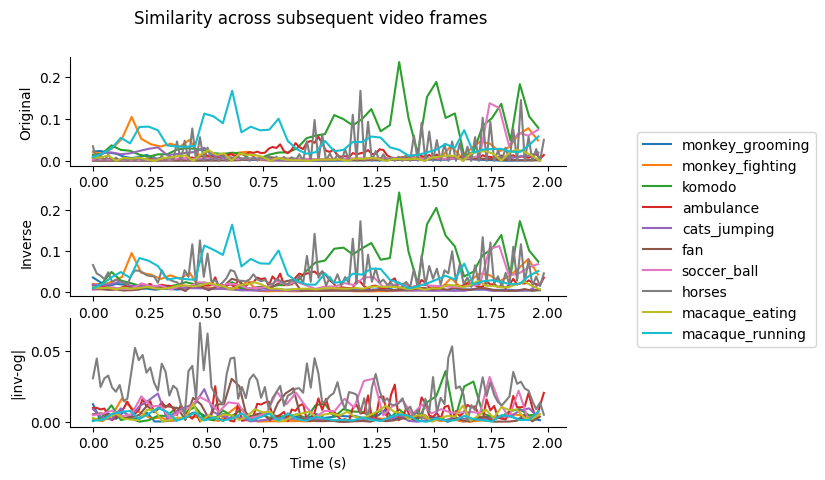

In [46]:
fig, axs = plt.subplots(3,1)

for key, value in frame_diff.items():
    
    mean_sim_frames = value['original']
    mean_sim_frames_inv = value['inverted']
    diff = value['diff']
    
    num_frames = len(mean_sim_frames)
    time = np.arange(num_frames)*2/num_frames

    axs[0].plot(time, mean_sim_frames, label=key)
    axs[1].plot(time, mean_sim_frames_inv, label=key)
    axs[2].plot(time, diff, label=key)
    
plt.suptitle('Similarity across subsequent video frames')
    
axs[0].set_ylabel('Original')
axs[1].set_ylabel('Inverse')
axs[2].set_ylabel('|inv-og|')
    
axs[2].set_xlabel('Time (s)')

categories = frame_diff.keys()
    
fig.legend(categories, loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

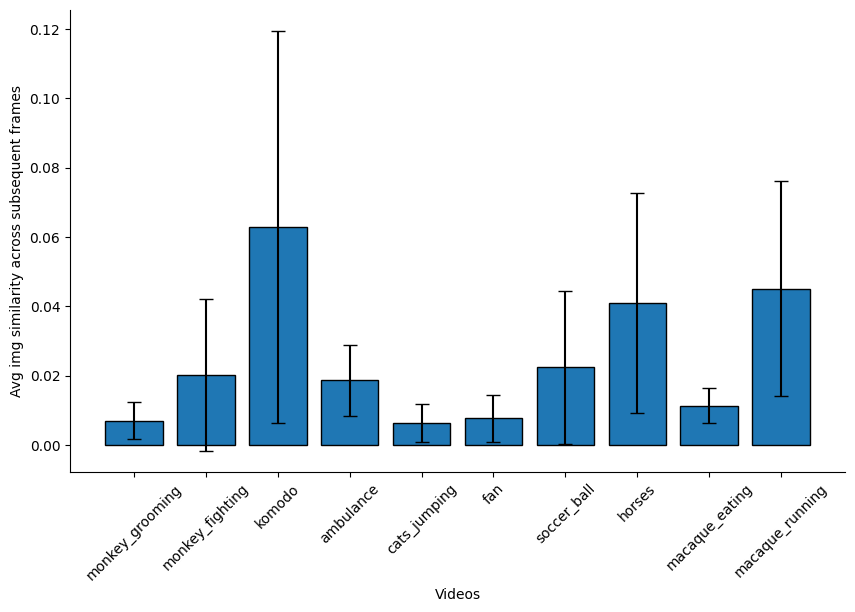

In [99]:
categories = list(frame_diff.keys())
means = [np.mean(values['inverted']) for values in frame_diff.values()]
errors = [np.std(values['inverted']) for values in frame_diff.values()]  # Use std dev as error bars

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=errors, capsize=5, edgecolor='black')

plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Videos')
plt.ylabel('Avg img similarity across subsequent frames')

plt.show()

In [48]:
og_inv_sim = {}

for folder in os.listdir(os.path.join(data_dir, 'videos_inverted')):
    if folder == '.DS_Store':
        continue
        
    path = os.path.join(data_dir, 'videos_inverted', folder)
    
    mean_sim, sim = get_image_similarity(path, path, 'original', 'inverted')
    
    og_inv_sim[folder] = mean_sim

The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set


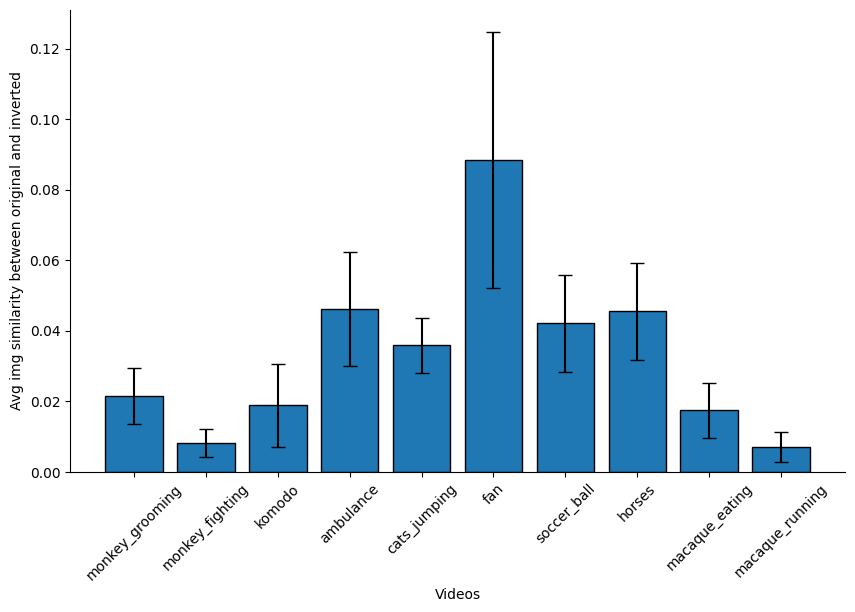

In [50]:
categories = list(og_inv_sim.keys())
means = [np.mean(values) for values in og_inv_sim.values()]
errors = [np.std(values) for values in og_inv_sim.values()]  # Use std dev as error bars

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=errors, capsize=5, edgecolor='black')

plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Videos')
plt.ylabel('Avg img similarity between original and inverted')

plt.show()

In [59]:
torch.from_numpy(np.asarray(cv2.imread(os.path.join(data_dir, 'imagenet_test', 'Group2', 'ILSVRC2012_test_00048466.JPEG')).transpose(2,0,1)).shape

(3, 500, 470)

In [ ]:
get_image_similarity(path1, path2, 'original', 'original)

In [6]:
def get_img_sim_random(path1, tag):
    
    images = [img for img in os.listdir(path1) if img.endswith(tag)]
    
    images_1 = images[:int(len(images)/2)]
    images_2 = images[int(len(images)/2):]
    
    if len(images_1) != len(images_2):
        images_1 = images_1[:min(len(images_1), len(images_2))]
        images_2 = images_2[:min(len(images_1), len(images_2))]
                            
    batch_1  = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path1, image)).transpose(2,0,1) for image in images_1]))
    batch_2 = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path1, image)).transpose(2,0,1) for image in images_2]))
    
    sim_scorer = TorchImageDistance()
    sim_scorer.first_image_batch = batch_1 
    sim_scorer.second_image_batch = batch_2
    
    mean_simmat, simmat = sim_scorer.get_CCN_distance()
    
    return mean_simmat, simmat
    

In [71]:
path1 = os.path.join(data_dir, 'imagenet_test_inverted')

mean_sim_rand, sim_rand = get_img_sim_random(path1,'original.png')
mean_sim_rand_inv, sim_rand_inv = get_img_sim_random(path1,'inverted.png')

The CNN scorers are set
The CNN scorers are set


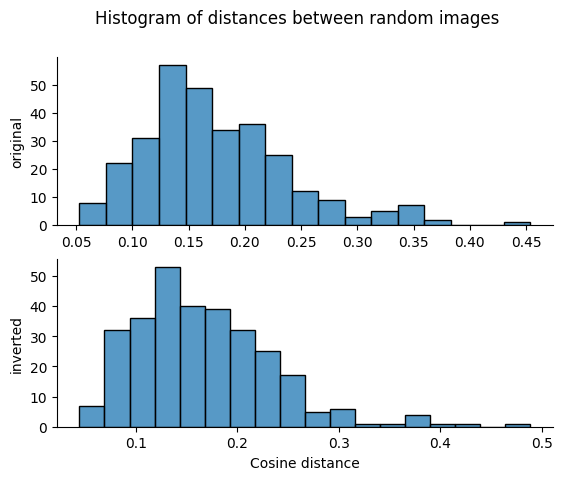

In [81]:
import seaborn as sns

fig, axs = plt.subplots(2,1)

sns.histplot(mean_sim_rand, ax=axs[0], label='original')
sns.histplot(mean_sim_rand_inv, ax=axs[1], label='inverted')

axs[0].set_ylabel('original')
axs[1].set_ylabel('inverted')
axs[1].set_xlabel('Cosine distance')

plt.suptitle('Histogram of distances between random images')

plt.show()

In [23]:
path1 = os.path.join(data_dir, 'videos_inverted', 'horses')

mean_sim_og_inv, sim_og_inv = get_image_similarity(path1, path1, 'original', 'inverted')

The CNN scorers are set


In [7]:
def get_img_dist_firstframe(path, tag):
    
    frames = count_frames(path, tag)
    
    images = [f'frame_{i}_{tag}.png' for i in range(frames)]
    
    images_1 = [images[0] for i in range(len(images)-1)]
    images_2 = images[1:]
    
    if len(images_1) != len(images_2):
        images_1 = images_1[:min(len(images_1), len(images_2))]
        images_2 = images_2[:min(len(images_1), len(images_2))]
                            
    batch_1  = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path, image)).transpose(2,0,1) for image in images_1]))
    batch_2 = torch.from_numpy(np.asarray([cv2.imread(os.path.join(path, image)).transpose(2,0,1) for image in images_2]))
    
    sim_scorer = TorchImageDistance()
    sim_scorer.first_image_batch = batch_1 
    sim_scorer.second_image_batch = batch_2
    
    mean_simmat, simmat = sim_scorer.get_CCN_distance()
    
    return mean_simmat, simmat

In [89]:
first_diff = {}


for folder in os.listdir(os.path.join(data_dir, 'videos_inverted')):
    if folder == '.DS_Store':
        continue
        
    path = os.path.join(data_dir, 'videos_inverted', folder)
    
    mean_sim_first, sim_first = get_img_dist_firstframe(path, 'original')
    mean_sim_first_inv, sim_first_inv = get_img_dist_firstframe(path, 'inverted')
    
    num_frames = len(mean_sim_first)
    time = np.arange(num_frames)*2/num_frames
    
    first_diff[folder] = {'original': mean_sim_first, 'inverted': mean_sim_first_inv, 'diff': np.abs(mean_sim_first_inv - mean_sim_first)}

The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set


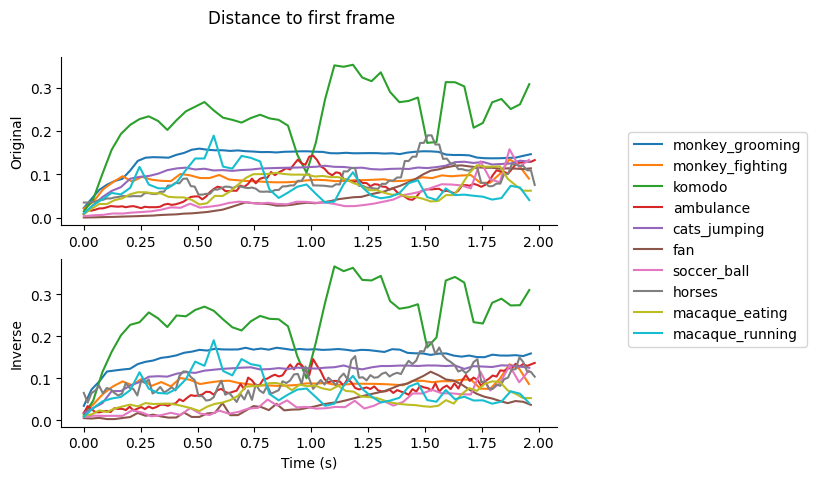

In [94]:
fig, axs = plt.subplots(2,1)

for key, value in first_diff.items():
    
    mean_sim_frames = value['original']
    mean_sim_frames_inv = value['inverted']
    diff = value['diff']
    
    num_frames = len(mean_sim_frames)
    time = np.arange(num_frames)*2/num_frames

    axs[0].plot(time, mean_sim_frames, label=key)
    axs[1].plot(time, mean_sim_frames_inv, label=key)
    
plt.suptitle('Distance to first frame')
    
axs[0].set_ylabel('Original')
axs[1].set_ylabel('Inverse')
    
axs[1].set_xlabel('Time (s)')

categories = first_diff.keys()
    
fig.legend(categories, loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

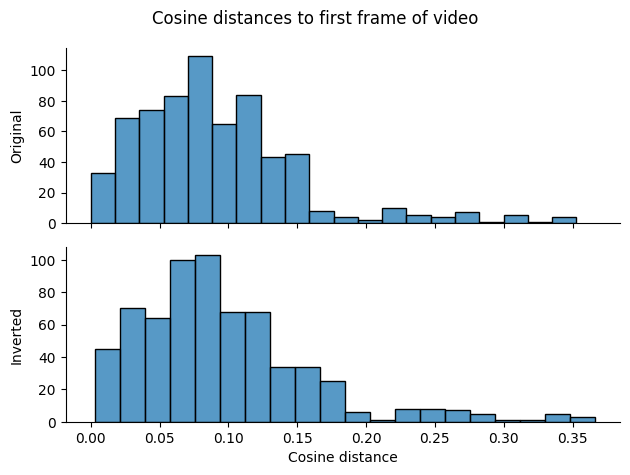

In [97]:
# Initialize lists to hold combined data across all folders
all_original = []
all_inverted = []
all_diff = []

# Combine the data from each folder
for folder_data in first_diff.values():
    all_original.extend(folder_data['original'])
    all_inverted.extend(folder_data['inverted'])
    all_diff.extend(folder_data['diff'])

# Plotting
fig, axs = plt.subplots(2, 1, sharex=True)

# Top plot: Mean similarity values for original and inverted
sns.histplot(all_original, bins=20, ax=axs[0], label='Original', edgecolor='black')
sns.histplot(all_inverted, bins=20, ax=axs[1], label='Inverted', edgecolor='black')

axs[0].set_ylabel('Original')

axs[1].set_xlabel('Cosine distance')
axs[1].set_ylabel('Inverted')

plt.suptitle('Cosine distances to first frame of video')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Comparisons for various perturbations

In [33]:
#pert_to_test = ['noise_0.1', 'noise_0.2', 'noise_0.3', 'noise_0.4', 'noise_0.5', 'noise_0.6', 'noise_0.7', 'noise_0.8']
pert_to_test = ['noise_0.4', 'noise_0.5', 'noise_0.6', 'noise_0.7']

perts = {} 

for pert in pert_to_test:
    pert_path = os.path.join(data_dir, 'images_perturbed_test', pert)
    
    fold_dict = {}
    
    for folder in os.listdir(pert_path):
        if folder == '.DS_Store':
            continue
            
        path = os.path.join(pert_path, folder)
        
        mean_sim_frames_inv, sim_frames_inv = get_similarity_frames(path, 'inverted')
        mean_sim_first_inv, sim_first_inv = get_img_dist_firstframe(path, 'inverted')
        
        fold_dict[folder] = {'sub_frame_diff': mean_sim_frames_inv, 'first_frame_diff': mean_sim_first_inv}
        
    perts[pert] = fold_dict
        
    

The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers are set
The CNN scorers 

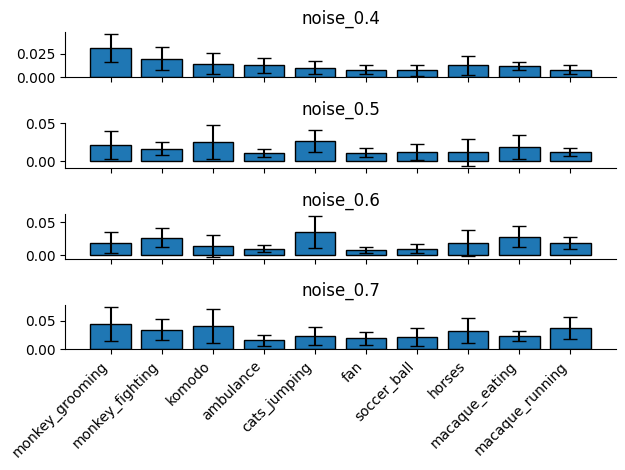

In [34]:
fig, axs = plt.subplots(len(perts.keys()), sharex=True)
                        
for i, key in enumerate(perts.keys()):
                        
    pert = perts[key]
    
    categories = list(pert.keys())
    
    means = [np.mean(values['sub_frame_diff']) for values in pert.values()]
    errors = [np.std(values['sub_frame_diff']) for values in pert.values()]  # Use std dev as error bars
    
    axs[i].bar(categories, means, yerr=errors, capsize=5, edgecolor='black')
    axs[i].set_title(key)
    
    axs[i].set_xlabel('')
    
    if i < len(perts.keys()) - 1:
        axs[i].tick_params(labelbottom=False)
    else:
        # Rotate x-tick labels by 45 degrees for the last subplot
        axs[i].set_xticklabels(categories, rotation=45, ha='right')
    
plt.tight_layout()
plt.show()
    
    

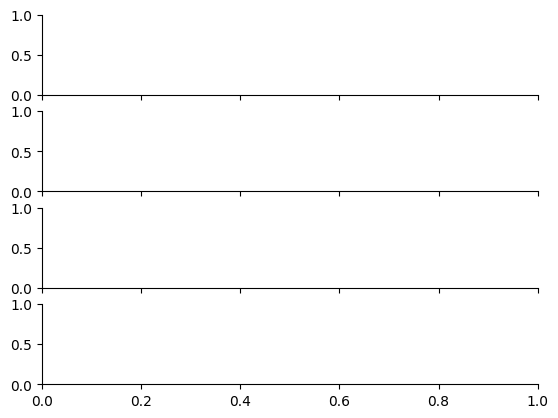

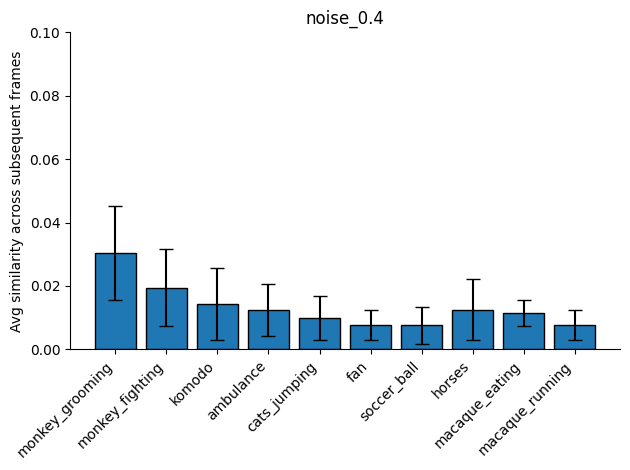

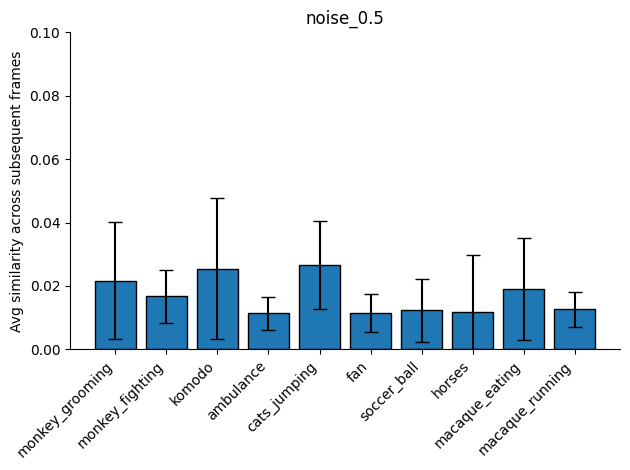

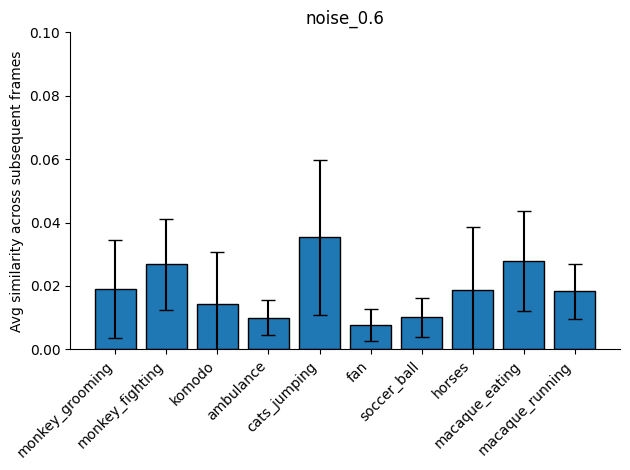

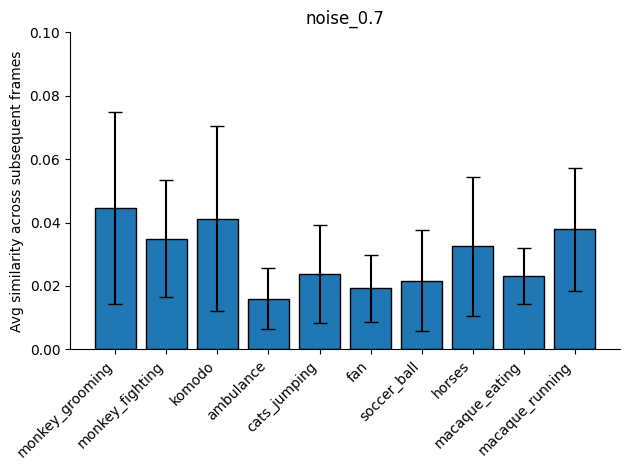

In [35]:

    
fig, axs = plt.subplots(len(perts.keys()), sharex=True)
                        
for i, key in enumerate(perts.keys()):
    fig = plt.figure()
                        
    pert = perts[key]
    
    categories = list(pert.keys())
    
    means = [np.mean(values['sub_frame_diff']) for values in pert.values()]
    errors = [np.std(values['sub_frame_diff']) for values in pert.values()]  # Use std dev as error bars
    
    plt.bar(categories, means, yerr=errors, capsize=5, edgecolor='black')
    plt.title(key)
    
    plt.xlabel('')
    plt.ylabel('Avg similarity across subsequent frames')
    
    
        # Rotate x-tick labels by 45 degrees for the last subplot
    plt.xticks(categories, rotation=45, ha='right')
    
    plt.ylim((0,0.1))
    
    plt.tight_layout()
    plt.show()
    
    

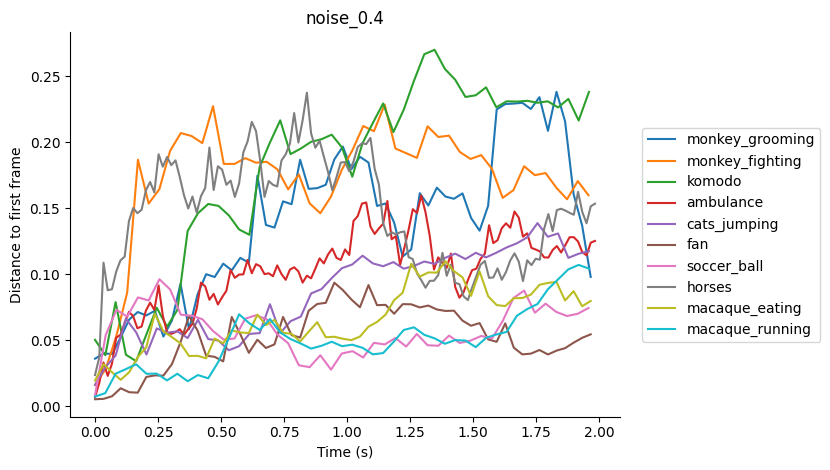

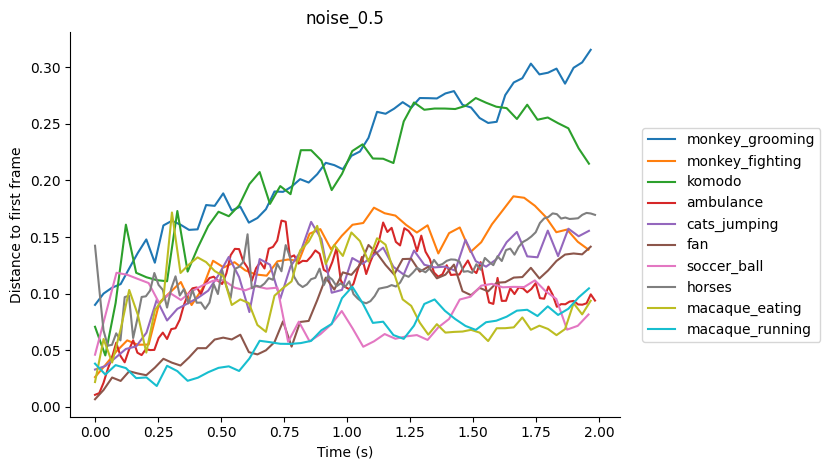

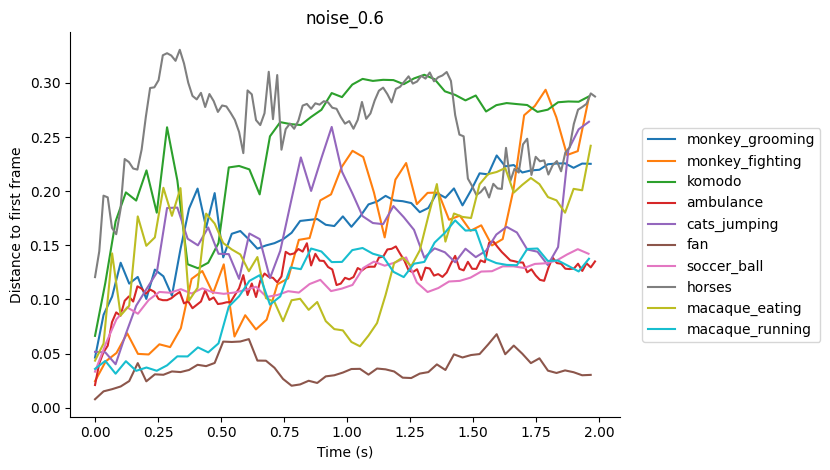

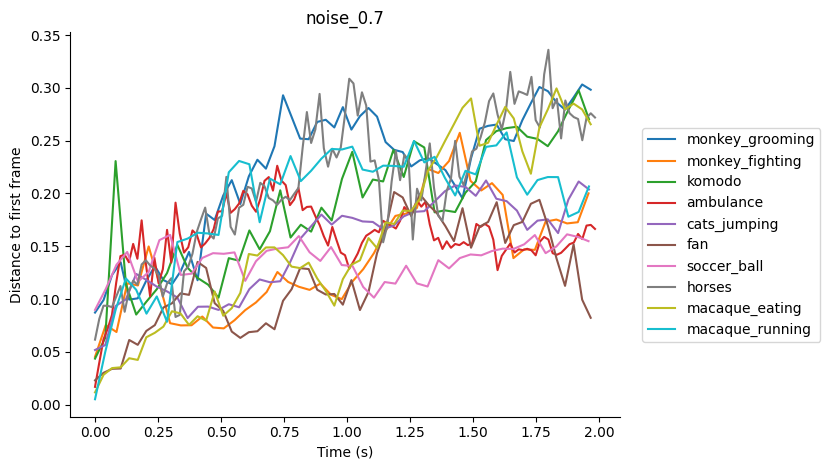

In [36]:
for i, pert_key in enumerate(perts.keys()):
    fig = plt.figure()
                        
    pert = perts[pert_key]
    
    categories = list(pert.keys())
    
    for key, value in pert.items():
        mean_sim = value['first_frame_diff']
        
        num_frames = len(mean_sim)
        time = np.arange(num_frames)*2/num_frames
        
        plt.plot(time, mean_sim, label=key)
        
    plt.ylabel('Distance to first frame')
    plt.title(pert_key)
    
    plt.xlabel('Time (s)')
    
    fig.legend(categories, loc='center left', bbox_to_anchor=(1, 0.5))

    
    plt.tight_layout()
    plt.show()
    
    

NameError: name 'first_diff' is not defined

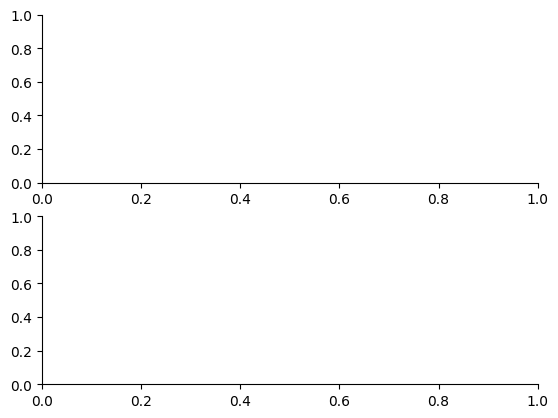

In [15]:
fig, axs = plt.subplots(2,1)

for key, value in first_diff.items():
    
    mean_sim_frames = value['original']
    mean_sim_frames_inv = value['inverted']
    diff = value['diff']
    
    num_frames = len(mean_sim_frames)
    time = np.arange(num_frames)*2/num_frames

    axs[0].plot(time, mean_sim_frames, label=key)
    axs[1].plot(time, mean_sim_frames_inv, label=key)
    
plt.suptitle('Distance to first frame')
    
axs[0].set_ylabel('Original')
axs[1].set_ylabel('Inverse')
    
axs[1].set_xlabel('Time (s)')

categories = first_diff.keys()
    
fig.legend(categories, loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

In [ ]:
categories = list(frame_diff.keys())
means = [np.mean(values['sub_frame_diff']) for values in frame_diff.values()]
errors = [np.std(values['sub_frame_diff']) for values in frame_diff.values()]  # Use std dev as error bars

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=errors, capsize=5, edgecolor='black')

plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Videos')
plt.ylabel('Avg img similarity across subsequent frames')

plt.show()

In [ ]:
frame_diff = {}

for folder in os.listdir(os.path.join(data_dir, 'videos_inverted')):
    if folder == '.DS_Store':
        continue
        
    path = os.path.join(data_dir, 'videos_inverted', folder)
    
    mean_sim_frames_inv, sim_frames_inv = get_similarity_frames(path, 'inverted')
    mean_sim_first_inv, sim_first_inv = get_img_dist_firstframe(path, 'inverted')
    
    num_frames = len(mean_sim_frames)
    time = np.arange(num_frames)*2/num_frames
    
    frame_diff[folder] = {'original': mean_sim_frames, 'inverted': mean_sim_frames_inv, 'diff': np.abs(mean_sim_frames_inv - mean_sim_frames)}